In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic

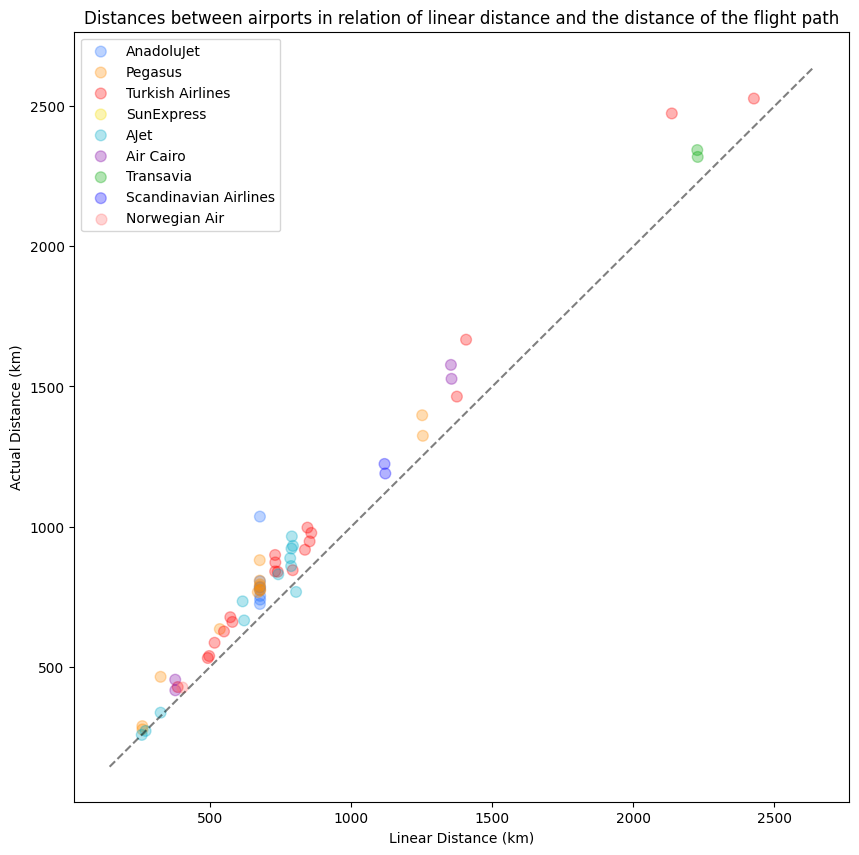

In [7]:
diary = pd.read_csv("../data-sources/cleandiary.csv")
paths = diary.PathFile.tolist()
diary["LinearDistance"] = np.nan
diary["FirstOnRadar"] = np.nan
diary["ActualDistance"] = np.nan
diary["ActualDeparture"] = np.nan
diary["ActualArrival"] = np.nan
diary["FlightTime"] = np.nan
diary["LastOnRadar"] = np.nan

for p in range(len(paths)):
    if (os.path.exists("../data-sources/allflights/"+paths[p]+".csv")):
        coords = pd.read_csv("../data-sources/allflights/"+paths[p]+".csv")
        startindex = (coords.Altitude != 0).idxmax()
        endindex = (coords.Altitude != 0).idxmin()
        if endindex == 0:
            endindex = coords.Altitude.size - 1
        startc = coords.Position[startindex]
        endc = coords.Position[endindex]
        timediff = coords.Timestamp[endindex] - coords.Timestamp[startindex]
        lineardistance = geodesic(startc,endc).meters
        actualdistance = 0
        diary.loc[p, "FirstOnRadar"] = coords.Timestamp[0]
        diary.loc[p, "LastOnRadar"] = coords.Timestamp.iat[-1]
        for i in range(startindex,endindex-1,1):
            actualdistance += geodesic(coords.Position[i],coords.Position[i+1]).meters
        diary.loc[p, "LinearDistance"] = lineardistance / 1000
        diary.loc[p, "ActualDistance"] = actualdistance / 1000
        diary.loc[p, "FlightTime"] = timediff
        diary.loc[p, "ActualDeparture"] = coords.Timestamp[startindex]
        diary.loc[p, "ActualArrival"] = coords.Timestamp[endindex]

fig, ax = plt.subplots(figsize=(10, 10))
for a in diary['Airline'].unique():
    scatterthis = diary[(diary['Airline']==a)]
    ax.scatter(scatterthis['LinearDistance'], scatterthis['ActualDistance'], alpha=0.3, s=60, label=a, c=scatterthis['AirlineColor'])

diary.to_csv("../data-sources/fixeddiary.csv", index=False)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'k--', alpha=0.5)
ax.set_xlabel('Linear Distance (km)')
ax.set_ylabel('Actual Distance (km)')
ax.set_title('Distances between airports in relation of linear distance and the distance of the flight path')
ax.legend()
plt.show()

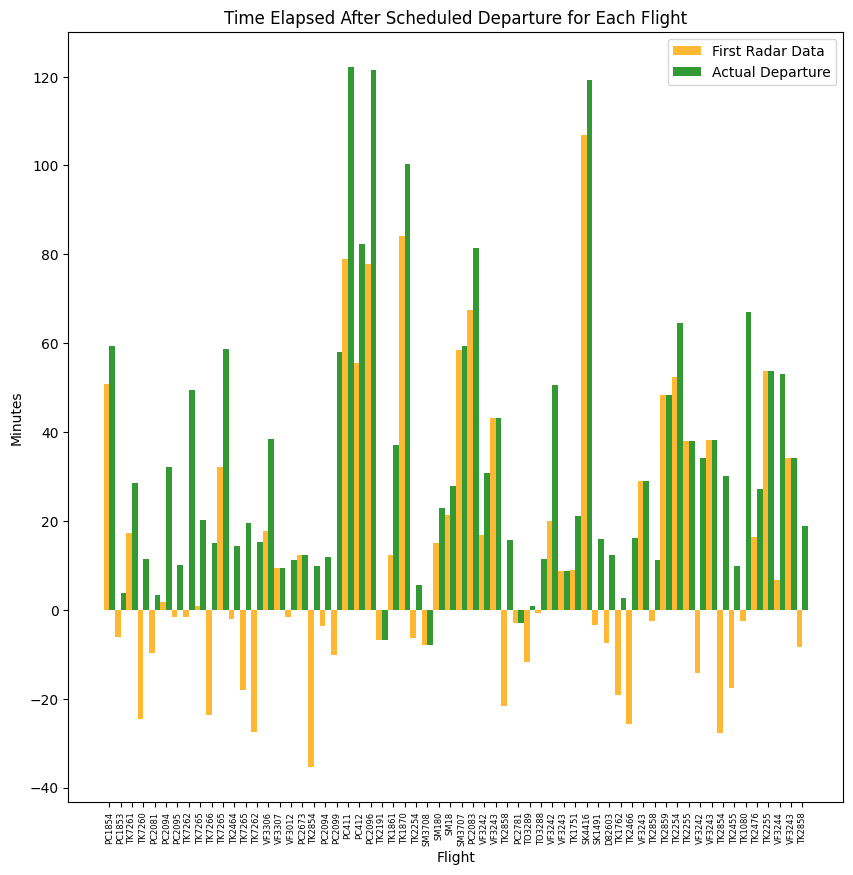

In [8]:
plottableflights = diary.copy()
plottableflights = plottableflights.dropna(subset=['LinearDistance', 'ActualDistance', 'FlightTime'])
plottableflights["FirstOnRadar"] = plottableflights["FirstOnRadar"].astype(int)
plottableflights["ActualDeparture"] = plottableflights["ActualDeparture"].astype(int)
plottableflights["ActualArrival"] = plottableflights["ActualArrival"].astype(int)
plottableflights["LastOnRadar"] = plottableflights["LastOnRadar"].astype(int)
plottableflights["FlightTime"] = plottableflights["FlightTime"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['FirstOnRadar']-plottableflights['Departure'])/60, 0.5, label='First Radar Data', alpha=0.8, color="#ffa600")
ax.bar(x + 0.25, (plottableflights['ActualDeparture']-plottableflights['Departure'])/60, 0.5, label='Actual Departure', alpha=0.8, color="green")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Departure for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()

plt.show()

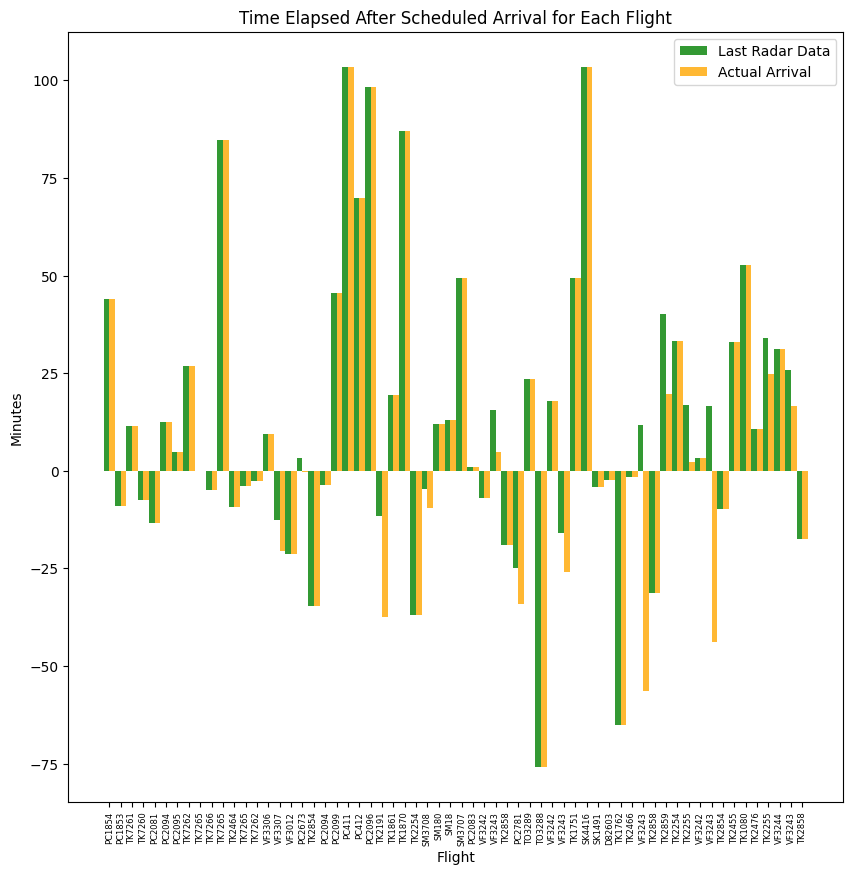

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['LastOnRadar']-plottableflights['Arrival'])/60, 0.5, label='Last Radar Data', alpha=0.8, color="green")
ax.bar(x + 0.25, (plottableflights['ActualArrival']-plottableflights['Arrival'])/60, 0.5, label='Actual Arrival', alpha=0.8, color="#ffa600")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Arrival for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()

plt.show()